In [1]:
# Basic set up
import cv2

import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor

import os
import time
import copy

# Uncomment if have bugs on GPU
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
# ===  Comment these out for local use === 
from google.colab import drive
drive.mount('/content/drive')
# ===                 ===              ===

datadir = '/content/drive/MyDrive/CS_FYP_archaeology/data_dummy/' # Change to local dir containing training data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Custom dataset inheriting the Pytorch generic Dataset
# Use this for higher flexibility, otherwise use ImageFolder for convenience
# Can modify the __getitem__ to customize the data structure returned from each sample
# Works for single folder containing data of all classes, uses csv_file to retrieve label for each image

class SherdDataSet(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
      """
      Args:
          csv_file (string): Path to the csv file with (img_path, label) for each row.
          root_dir (string): Directory with all the images.
          transform (callable, optional): Optional transform to be applied
              on a sample.
      """
      self.sherds_frame = pd.read_csv(csv_file)
      self.root_dir = root_dir
      self.transform = transform

    def __len__(self):
      return len(self.sherds_frame)

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
          idx = idx.tolist()

      img_name = os.path.join(self.root_dir, self.sherds_frame.iloc[idx, 0])
      sherd_img = cv2.imread(img_name)
      sherd_label = self.sherds_frame.iloc[idx, 1]

      if self.transform:
          sample = self.transform(sherd_img)

      sample = {'image': sherd_img, 'label': sherd_label}

      return sample

In [4]:
def target_to_oh(target):
    NUM_CLASS = 92  # hard code here, can do partial
    one_hot = torch.eye(NUM_CLASS)[target]
    return one_hot

In [21]:
# Loading dataset using default Pytorch ImageFolder
# Assumes the data structure shown above classified by label into subfolders

# Defines the transformation done to each input data prior to being fed into the model
def create_transform(resize_size=None, crop_size=None):
  if resize_size and crop_size:
    resize_size = resize_size
    crop_size = crop_size
    # Always ToTensor to be fed into pytorch layers
    transform = transforms.Compose([transforms.Resize(resize_size), transforms.CenterCrop(crop_size), transforms.ToTensor()])
  elif resize_size:
    transform = transforms.Compose([transforms.Resize(resize_size), transforms.ToTensor()])
  elif crop_size:
    transform = transforms.Compose([transforms.CenterCrop(crop_size), transforms.ToTensor()])
  else:
    transform = ToTensor()
  return transform

ds = torchvision.datasets.ImageFolder(root=os.path.join(datadir, 'train'), transform=create_transform(255, 224),target_transform=target_to_oh)

In [65]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

def inverse_normalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor



def imshow(img): 
  if img.shape[1] >= 1000 and img.shape[1] >= img.shape[0] :
    width = 1000
    height = int(img.shape[0] * 1000 / img.shape[1])
    dim = (width, height)
    # # resize image
    # resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    img = cv2.resize(img, dim)   
  elif img.shape[0] >= 1000 and img.shape[0] >= img.shape[1]:
    width = int(img.shape[1] * 1000 / img.shape[0])
    height = 1000
    dim = (width, height)   
    # # resize image
    # resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    img = cv2.resize(img, dim)
  cv2_imshow(img)

# Shows an image tensor using opencv
# Gives all black? How to show properly without plt?
def imshow_tensor(img_tensor):
  img_tensor = inverse_normalize(tensor=img_tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
  imshow(img_tensor.numpy().transpose(1, 2, 0))


def imshow_tensor_plt(img_tensor, ax=None, title=None, normalize=True):
  """Imshow for Tensor."""
  if ax is None:
      fig, ax = plt.subplots()
  img_tensor = img_tensor.numpy().transpose((1, 2, 0))

  if normalize:
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      img_tensor = std * img_tensor + mean
      img_tensor = np.clip(img_tensor, 0, 1)

  ax.imshow(img_tensor)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.tick_params(axis='both', length=0)
  ax.set_xticklabels('')
  ax.set_yticklabels('')

  return ax


def imshow_list(inp, title=None, normalize=True):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    if normalize:
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      inp = std * inp + mean
      inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [14]:
# Loops through dataset
count = 0
for images, labels in ds:
  if count > 10:
    break

  print(type(images))
  print(labels)

  count += 1

<class 'torch.Tensor'>
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
<class 'torch.Tensor'>
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
<class 'torch.Tensor'>
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0

In [13]:
# Inspect the classes
list_of_classes = list(ds.classes)
list_of_classes

['black fine', 'red coarse']

In [15]:
dataloader = torch.utils.data.DataLoader(ds, batch_size=2) # Can specify batch_size=1 and shuffle=False


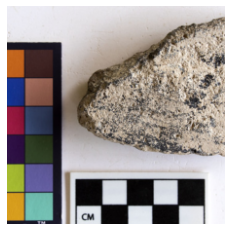

In [16]:
# Get one batch
images, labels = next(iter(dataloader))
imshow_tensor_plt(images[0], normalize=False)

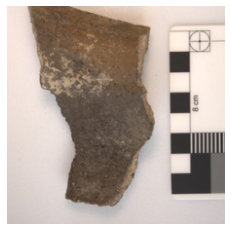

In [17]:
imshow_tensor_plt(images[1], normalize=False)

In [30]:
data_dir = '/content/drive/MyDrive/CS_FYP_archaeology/data_dummy'
batch_size = 2



# Certain models e.g. Inception v3 requires certain size of images
# Skipping normalization here
# Assumes data images are all 170x170
data_transforms = {
    'train': create_transform(crop_size=128),
    'val': create_transform(crop_size=128)
}

# Pytorch losses like CELoss do not required one-hot labels

# image_datasets = {x: datasets.ImageFolder(root=os.path.join(data_dir, x),
#                   transform=data_transforms[x], target_transform=target_to_oh)
#                   for x in ['train', 'val']}


image_datasets = {x: datasets.ImageFolder(root=os.path.join(data_dir, x), transform=data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                shuffle=True)
                for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [84]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            # Modes determine activation of dropout layers
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # clear the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # logits of shape (N, C) where N is batch size, C is # classes
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels) # if CELoss: outputs=unnormalized logits; labels=class indices vector of shape (N)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0) # if CELoss: loss is scalar from logSoftmax and NLLLoss
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step() # Decays learning rate. If not using scheduler, replace with optimizer.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
            else:
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)


        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)


    histories = (train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model, histories

# TODO: Write test function
# Remember to set model.eval()
# and use with torch.no_grad():

def test_model(model, num_samples):


    testset = datasets.ImageFolder(root=os.path.join(data_dir, 'test'), transform=create_transform(crop_size=128))
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                shuffle=True)

    correct = 0
    total = 0
    samples_used = 0
  
    was_training = model.training
    model.eval()

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

            for j in range(inputs.size()[0]):
                samples_used += 1
                row_num = max(num_samples//2, 1)
                ax = plt.subplot(row_num, 3, samples_used)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')

                imshow_list(inputs.cpu().data[j], normalize=False)

                if samples_used >= num_samples:
                    model.train(mode=was_training)
                    print(f'Accuracy on test images: {100 * correct // total} %')
                    return

        model.train(mode=was_training)

    print(f'Accuracy on test images: {100 * correct // total} %')




In [32]:
'''
ResNet18 last layer:
(fc): Linear(in_features=512, out_features=1000, bias=True)

Reinitialize last layer with number of classes:
model.fc = nn.Linear(512, num_classes)


'''
# Initialize Resnet18 model for finetuning

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to len(class_names) i.e. number of classes.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

# Compares unnormalized logits and vector of label indices
criterion = nn.CrossEntropyLoss()

# All parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [53]:
# Actual Training
model_ft_trained, histories = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)


Epoch 0/99
----------
train Loss: 0.7565 Acc: 0.5000
val Loss: 0.3207 Acc: 0.7500

Epoch 1/99
----------
train Loss: 0.0186 Acc: 1.0000
val Loss: 0.3232 Acc: 0.7500

Epoch 2/99
----------
train Loss: 0.7565 Acc: 0.5000
val Loss: 0.3261 Acc: 0.7500

Epoch 3/99
----------
train Loss: 0.7565 Acc: 0.5000
val Loss: 0.3219 Acc: 0.7500

Epoch 4/99
----------
train Loss: 0.0233 Acc: 1.0000
val Loss: 0.3132 Acc: 0.7500

Epoch 5/99
----------
train Loss: 0.0233 Acc: 1.0000
val Loss: 0.3004 Acc: 0.7500

Epoch 6/99
----------
train Loss: 0.7565 Acc: 0.5000
val Loss: 0.2836 Acc: 0.7500

Epoch 7/99
----------
train Loss: 0.7565 Acc: 0.5000
val Loss: 0.2675 Acc: 0.7500

Epoch 8/99
----------
train Loss: 0.0233 Acc: 1.0000
val Loss: 0.2606 Acc: 0.7500

Epoch 9/99
----------
train Loss: 0.0186 Acc: 1.0000
val Loss: 0.2727 Acc: 0.7500

Epoch 10/99
----------
train Loss: 0.0186 Acc: 1.0000
val Loss: 0.2759 Acc: 0.7500

Epoch 11/99
----------
train Loss: 0.0186 Acc: 1.0000
val Loss: 0.2739 Acc: 0.7500

Ep

In [ ]:
print(model_ft_trained)

In [51]:
# Takes in histories object which is a tuple of length 4
# Shows the variations of lossses and accuracies over epochs
def plot_histories(histories):
    train_loss_history, val_loss_history, train_acc_history, val_acc_history = histories

    epochs = range(1, len(train_loss_history) + 1)

    plt.plot(epochs, train_acc_history, 'r', label='Training acc')
    plt.plot(epochs, val_acc_history, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, train_loss_history, 'r', label='Training loss')
    plt.plot(epochs, val_loss_history, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

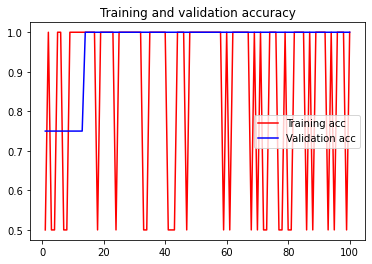

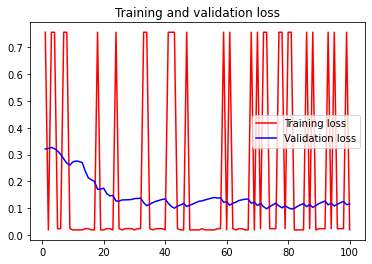

In [54]:
plot_histories(histories)


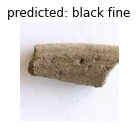

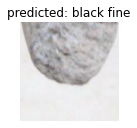

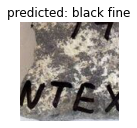

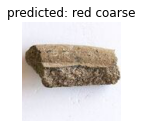

Accuracy on test images: 75 %


In [86]:
test_model(model_ft_trained, 4)